# Get the MURK genes for GO analysis Figure 6C, Figure 6B and rank the change in slope

In [1]:
import pandas as pd
import scvelo as scv
import numpy as np
import scanpy as sc
import scipy

In [2]:
scv.settings.vector_friendly = False
scv.set_figure_params( dpi=300, dpi_save = 300, frameon=False, figsize = (7,5), format='png',fontsize=30)

In [3]:
# Read data

In [4]:
adata = scv.read('adata_qc.h5')

In [5]:
adata_pca = scv.read('adata_human_def.h5')
adata_store = adata_pca.copy()

Prepare object

In [6]:
# Define object characteristics

In [7]:
population_names = ['MEMP','Early Erythroid',  'Mid  Erythroid', 'Late Erythroid']

In [8]:
# Preprocessing 

In [9]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean=0.07,min_disp=0.2)
list_hvg = adata.var_names[adata.var.highly_variable]

scv.pp.filter_and_normalize(adata_pca, min_shared_counts = 20, n_top_genes = 1000)
list_scv = adata_pca.var_names

list_out = [gene for gene in list_scv if gene not in list_hvg]
list_tot = list(list_hvg)

list_tot.extend(list_out)

Filtered out 21711 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Logarithmized X.


In [10]:
# Imputation

In [11]:
adata = adata_store[:,list_tot].copy()
scv.pp.filter_and_normalize(adata)
scv.pp.moments(adata,n_neighbors=80)

Normalized count data: X, spliced, unspliced.
Logarithmized X.
computing neighbors
    finished (0:00:45) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:13) --> added 
    'Ms' and 'Mu', moments of spliced/unspliced abundances (adata.layers)


In [12]:
adata.write('adata_for_velocity.h5')

Murk genes research

In [13]:
# Linear regression model: compute a slope for each gene and each population in phase plot space and store them in two dataframes

In [14]:
# initialize matrix for spliced (mat_s) and unspliced (unspliced) counts
mat_s = pd.DataFrame(adata.layers['Ms'].copy())
mat_u = pd.DataFrame(adata.layers['Mu'].copy())
mat_s.index = adata.obs_names
mat_s.columns = adata.var_names
mat_u.index = adata.obs_names
mat_u.columns = adata.var_names

In [15]:
# initialize dataframes for slopes (df_sl) and slope error (df_ds)

df_sl = pd.DataFrame(index=adata.var_names)
df_db = pd.DataFrame(index=adata.var_names)

In [16]:
# initialize dataframes for expression (df_exp), expression error (df_de) and 95% quantile (df_quant)

for pop in population_names:
    print(pop)
    vec = adata.obs['type2'] == pop
    
    x = mat_s.loc[vec]
    y = mat_u.loc[vec]
    
    mx = np.mean(x)
    my = np.mean(y)
    x_mx = x - mx
    y_my = y - my
    xy = np.sum(x_mx * y_my, axis = 0)
    X2 = np.sum(x_mx**2,axis = 0)
    sl = xy / X2
    inter = my - sl * mx
    n = np.sum(vec)
                
    df_sl[pop] = pd.DataFrame(sl)
   
    
    pred = sl * x + inter
    sse = (pred - y)**2
    SSE = np.sum(sse, axis = 0)
                
    db = np.sqrt(SSE/(n-2)/X2)
    df_db[pop] = pd.DataFrame(db)
    
    dq = np.sqrt(SSE * (1/n + mx**2/X2)/ (n-2))

MEMP
Early Erythroid
Mid  Erythroid
Late Erythroid


In [17]:
# initialize dataframes for expression (df_exp), expression error (df_de), unspliced counts (df_unsp) 95% quantile (df_quant)
df_exp = pd.DataFrame(index=adata.var_names)
df_de = pd.DataFrame(index=adata.var_names)
df_quan = pd.DataFrame(index = adata.var_names)
df_unsp = pd.DataFrame(index=adata.var_names)
# df_du = pd.DataFrame(index=adata.var_names)

In [18]:
# compute average expression and its error
for pop in population_names:
    print(pop)
    vec = adata.obs['type2'] == pop
    n = np.sum(vec)
    expr = np.mean(mat_s.loc[vec],axis =0)
    dex = np.std(mat_s.loc[vec],axis =0)/np.sqrt(n)
    
    df_exp[pop] = pd.DataFrame(expr)
    df_de[pop] = pd.DataFrame(dex)



for pop in population_names:
    print(pop)
    vec = adata.obs['type2'] == pop
    n = np.sum(vec)
    unsp = np.mean(mat_u.loc[vec],axis =0)
#     de_u = np.std(mat_u.loc[vec],axis =0)/np.sqrt(n)
    
    df_unsp[pop] = pd.DataFrame(unsp)
#     df_du[pop] = pd.DataFrame(de_u)

MEMP
Early Erythroid
Mid  Erythroid
Late Erythroid
MEMP
Early Erythroid
Mid  Erythroid
Late Erythroid


In [19]:
# compute average expression and its error

for pop in population_names:
    vec = adata.obs['type2'] == pop
    n = np.sum(vec)
    
    df_quan[pop] = scipy.stats.t.ppf(0.95, n - 1)

df_conf = df_db * df_quan

df_min = df_sl - df_conf
df_max = df_sl + df_conf

In [20]:
# decide if a change is slope is significative (Erythroid 3 expressed more than the others, its minimum slope grater than the previous maximum slope and positive)

vec_mean = ((df_exp['Late Erythroid'] >  df_exp['Mid  Erythroid'])
            &(df_exp['Late Erythroid'] >  df_exp['Early Erythroid'])
            &(df_exp['Late Erythroid'] >  df_exp['MEMP']))

vec_uns = ((df_unsp['Late Erythroid'] >  df_unsp['Mid  Erythroid'])
            &(df_unsp['Late Erythroid'] >  df_unsp['Early Erythroid']))

vec_pos =  df_min['Late Erythroid']>0

vec_test = df_min['Late Erythroid'] > df_max['Mid  Erythroid']

vec_tot =  ((np.array(vec_mean) & np.array(vec_pos) & np.array(vec_test) & np.array(vec_uns)) |
            (np.array(((df_exp['Late Erythroid'] >  df_exp['Early Erythroid'])&(df_exp['Late Erythroid'] >  df_exp['MEMP']))) & np.array(df_min['Late Erythroid']<0)  & np.array(vec_uns)))

In [21]:
# How many MURK genes
np.sum(vec_tot)

97

In [22]:
# MURK genes for GO analysis Figure 6C
murk_genes = adata.var_names[vec_tot]
pd.DataFrame(murk_genes).to_csv('murk_genes_human.csv', index=None,header=None)

saving figure to file ./figures/scvelo_phase_plots_human_correct.png


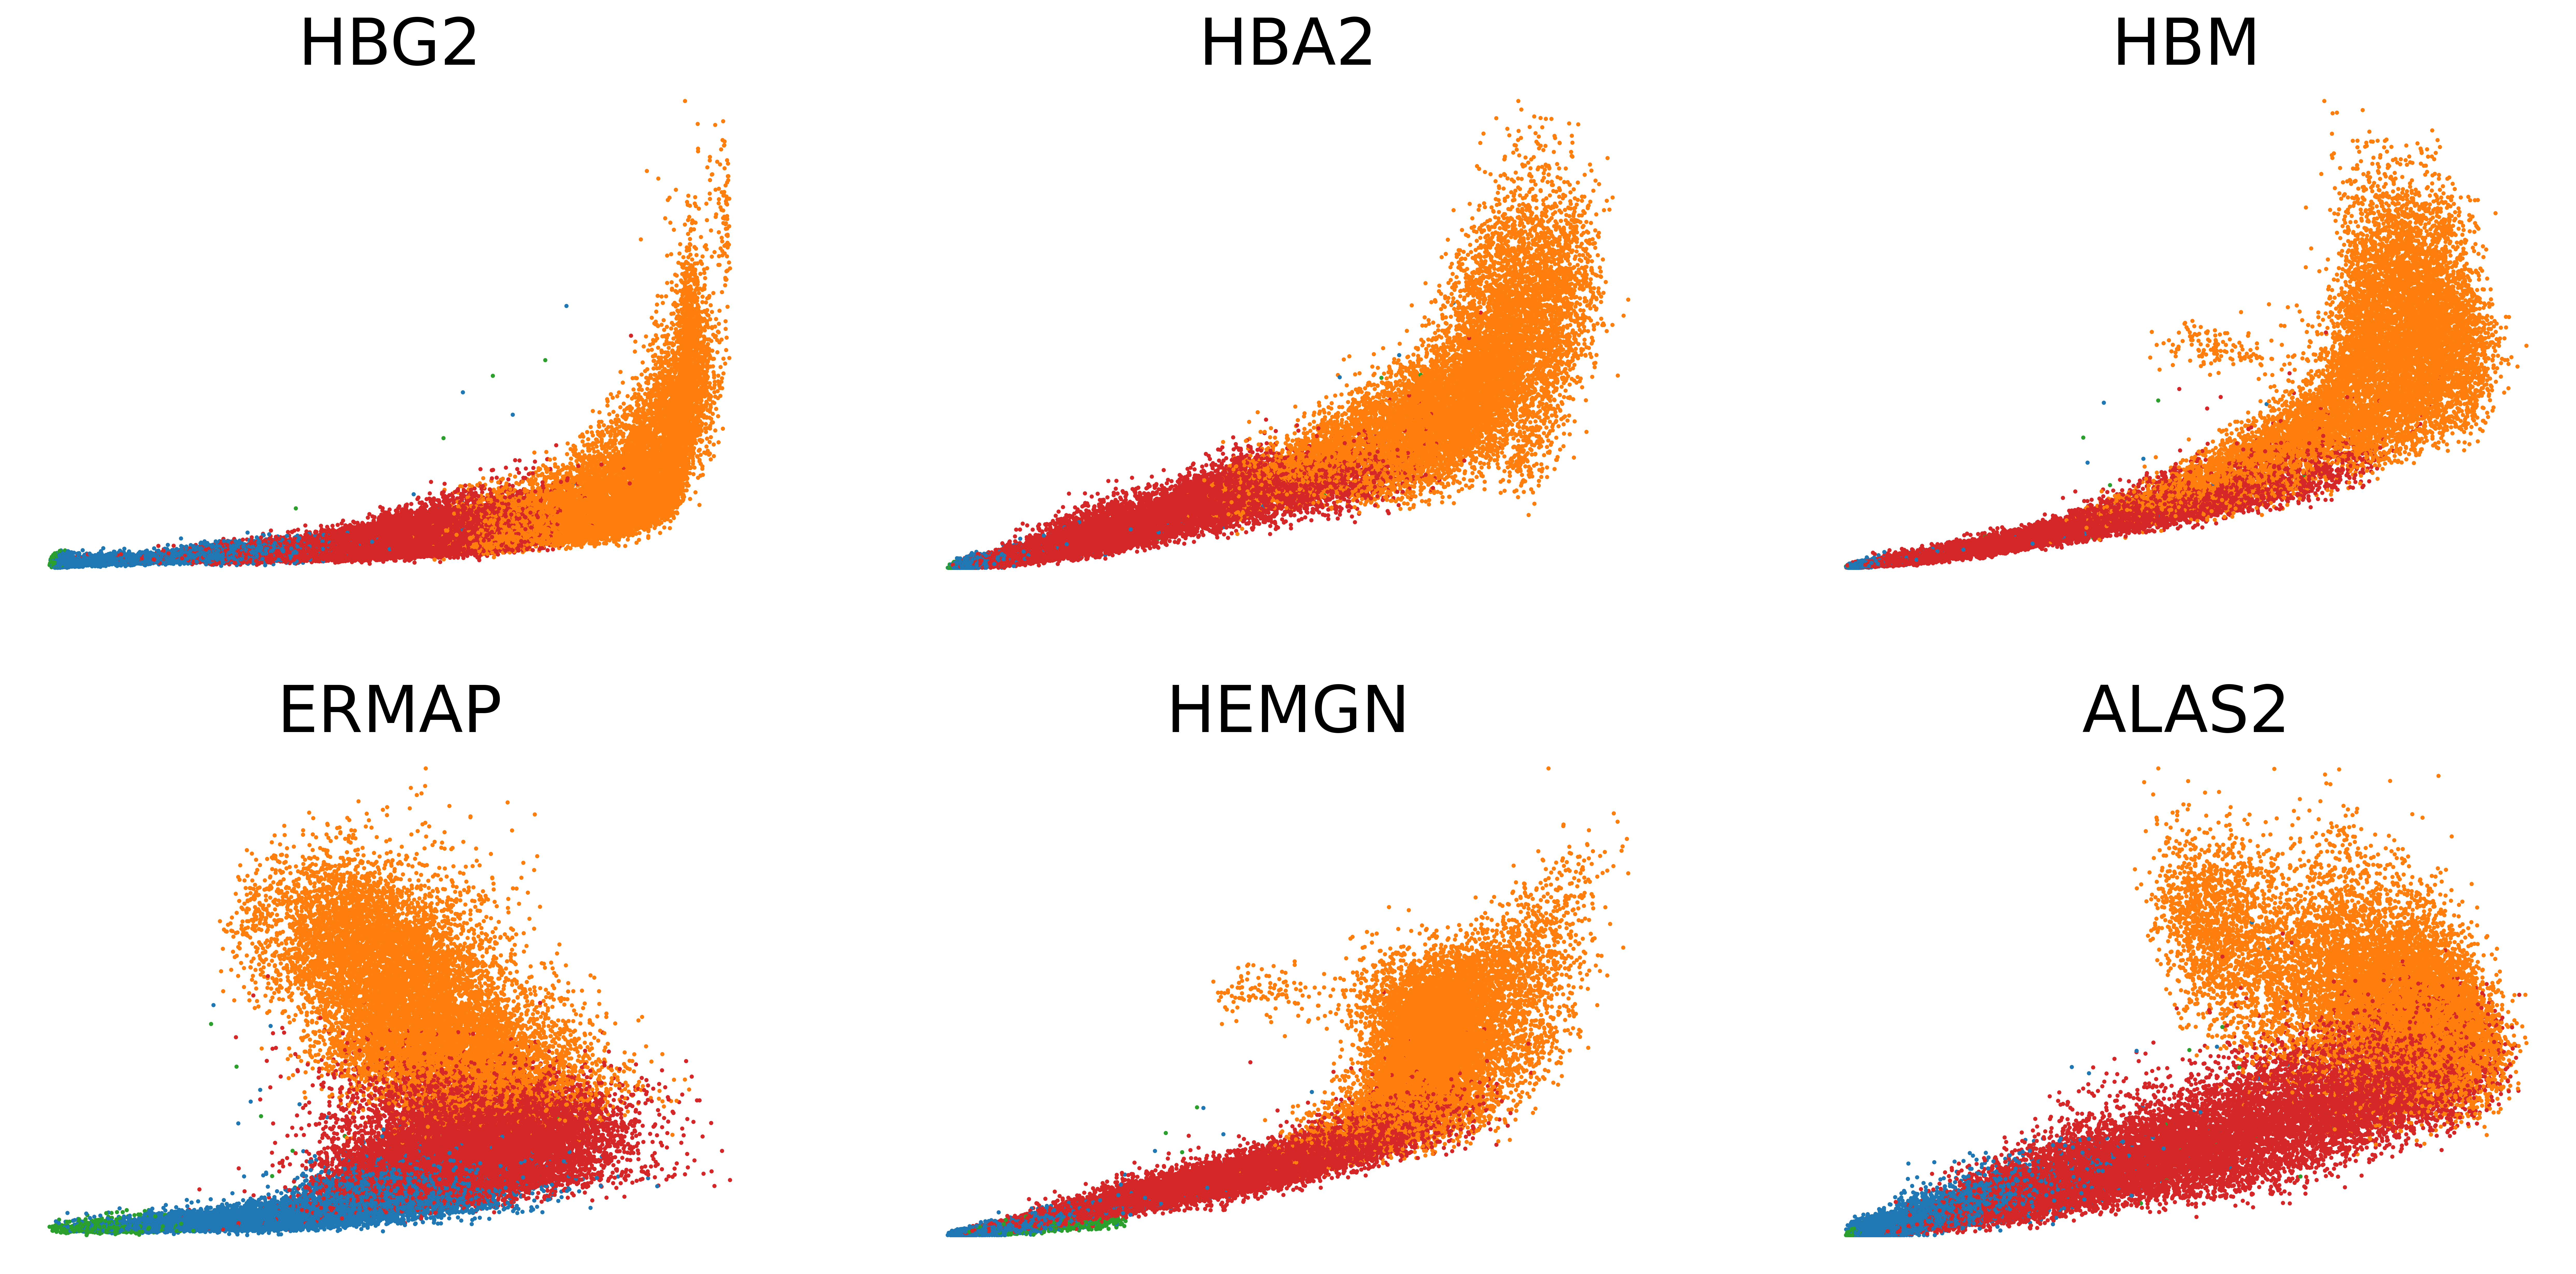

In [23]:
scv.pl.scatter(adata, basis = ['HBG2','HBA2','HBM','ERMAP','HEMGN','ALAS2'], ncols=3,color = 'type2',frameon = False,s = 15,linewidth=3,save = 'phase_plots_human_correct.png')

In [24]:
# Recalculate the slopes scaling for the avarage of gene expression in order to range the genes for "MURKiness"

df_sl2 = pd.DataFrame(index=adata.var_names)

for pop in population_names:
    print(pop)
    vec = adata.obs['type2'] == pop
    
    x = mat_s.loc[vec]/np.max(mat_s.loc[vec])
    y = mat_u.loc[vec]/np.max(mat_u.loc[vec])
    
    mx = np.mean(x)
    my = np.mean(y)
    x_mx = x - mx
    y_my = y - my
    xy = np.abs(np.sum(x_mx * y_my, axis = 0))
    X2 = np.sum(x_mx**2,axis = 0)
    sl = xy / X2

    df_sl2[pop] = pd.DataFrame(sl)

MEMP
Early Erythroid
Mid  Erythroid
Late Erythroid


In [25]:
# Rank genes: higher difference in scaled slope ranks higher
df_rank = pd.DataFrame((df_min['Late Erythroid'] - df_max['Mid  Erythroid']))

vec1 = np.array((df_max['Late Erythroid']<0) & (df_min['Mid  Erythroid']<0))

df_rank.loc[vec1] = pd.DataFrame(-df_max.loc[vec1]['Late Erythroid'] + df_min.loc[vec1]['Mid  Erythroid'])

vec2 = np.array((df_max['Late Erythroid']<0) & (df_min['Mid  Erythroid']>0))

df_rank.loc[vec2] = pd.DataFrame(-df_max.loc[vec2]['Late Erythroid'] + df_min.loc[vec2]['Mid  Erythroid'])


df_rank.columns = ['\u0394'+'m']
df_rank['scaled \u0394'+'m'] = np.abs(df_sl2['Late Erythroid'] - df_sl2['Mid  Erythroid'])



df_fin = df_rank.loc[murk_genes].sort_values(by = 'scaled \u0394'+'m',ascending = False)

df_fin.to_csv('ranked_murk_genes_human.csv')